In [1]:
%load_ext autoreload
%autoreload 2|

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import seaborn as sn
from lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter
from lifelines import CoxPHFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
import lifelines
import models
import torch
from pycox.models import DeepHitSingle
import warnings
import utils

import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from ray import tune
pd.set_option('display.max_columns', None)


In [3]:
df = utils.get_unprocessed_dataset()[0]
df.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,YES,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,0:LIVING,Negative,YES,138.65,0:Not Recurred,1,Primary,Female,ER-/HER2-,0.000000,22.0,2.0,Living
1,brca_metabric,MB-0002,MB-0002,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,YES,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,0:LIVING,Positive,YES,83.52,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,10.0,1.0,Living
2,brca_metabric,MB-0005,MB-0005,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,YES,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,1:DECEASED,Positive,NO,151.28,1:Recurred,1,Primary,Female,NaN,2.615035,15.0,2.0,Died of Disease
3,brca_metabric,MB-0006,MB-0006,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,YES,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,0:LIVING,Positive,YES,162.76,0:Not Recurred,1,Primary,Female,NaN,1.307518,25.0,2.0,Living
4,brca_metabric,MB-0008,MB-0008,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,YES,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,1:DECEASED,Positive,YES,18.55,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,40.0,2.0,Died of Disease


## Test set

In [4]:
df_clear, event_col, duration_col = utils.get_processed_dataset()
df_train, df_test = utils.split_dataset(df_clear)
df_train

,Age at Diagnosis,Cohort,Neoplasm Histologic Grade,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Overall Survival (Months),Tumor Size,Tumor Stage,Censorship,Type of Breast Surgery_MASTECTOMY,Cellularity_Low,Cellularity_Moderate,Chemotherapy_YES,Pam50 + Claudin-low subtype_Basal,Pam50 + Claudin-low subtype_Her2,Pam50 + Claudin-low subtype_LumA,Pam50 + Claudin-low subtype_LumB,Pam50 + Claudin-low subtype_Normal,Pam50 + Claudin-low subtype_claudin-low,ER status measured by IHC_Positve,ER Status_Positive,HER2 status measured by SNP6_GAIN,HER2 status measured by SNP6_LOSS,HER2 status measured by SNP6_NEUTRAL,HER2 Status_Positive,Hormone Therapy_YES,Inferred Menopausal State_Pre,Integrative Cluster_10,Integrative Cluster_2,Integrative Cluster_3,Integrative Cluster_4ER+,Integrative Cluster_4ER-,Integrative Cluster_5,Integrative Cluster_6,Integrative Cluster_7,Integrative Cluster_8,Integrative Cluster_9,Primary Tumor Laterality_Right,PR Status_Positive,Radio Therapy_YES,3-Gene classifier subtype_ER+/HER2- Low Prolif,3-Gene classifier subtype_ER-/HER2-,3-Gene classifier subtype_HER2+
22,45.43,1.0,3.0,0.0,5.0,4.046,140.866667,23.0,2.0,True,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
1448,54.96,3.0,3.0,1.0,7.0,5.050,183.433333,25.0,2.0,True,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1170,39.25,3.0,3.0,0.0,12.0,4.030,56.333333,15.0,1.0,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1289,75.53,3.0,3.0,0.0,5.0,4.030,200.600000,15.0,1.0,True,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1010,50.08,3.0,3.0,1.0,15.0,5.074,42.666667,37.0,2.0,False,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,83.01,1.0,2.0,1.0,3.0,4.044,144.700000,22.0,2.0,False,1,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
693,48.34,2.0,1.0,2.0,5.0,3.054,252.333333,27.0,2.0,True,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
228,74.76,1.0,3.0,1.0,1.0,5.044,170.633333,22.0,2.0,False,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0
1544,40.37,3.0,2.0,0.0,4.0,3.050,123.700000,25.0,2.0,True,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0


<AxesSubplot: >

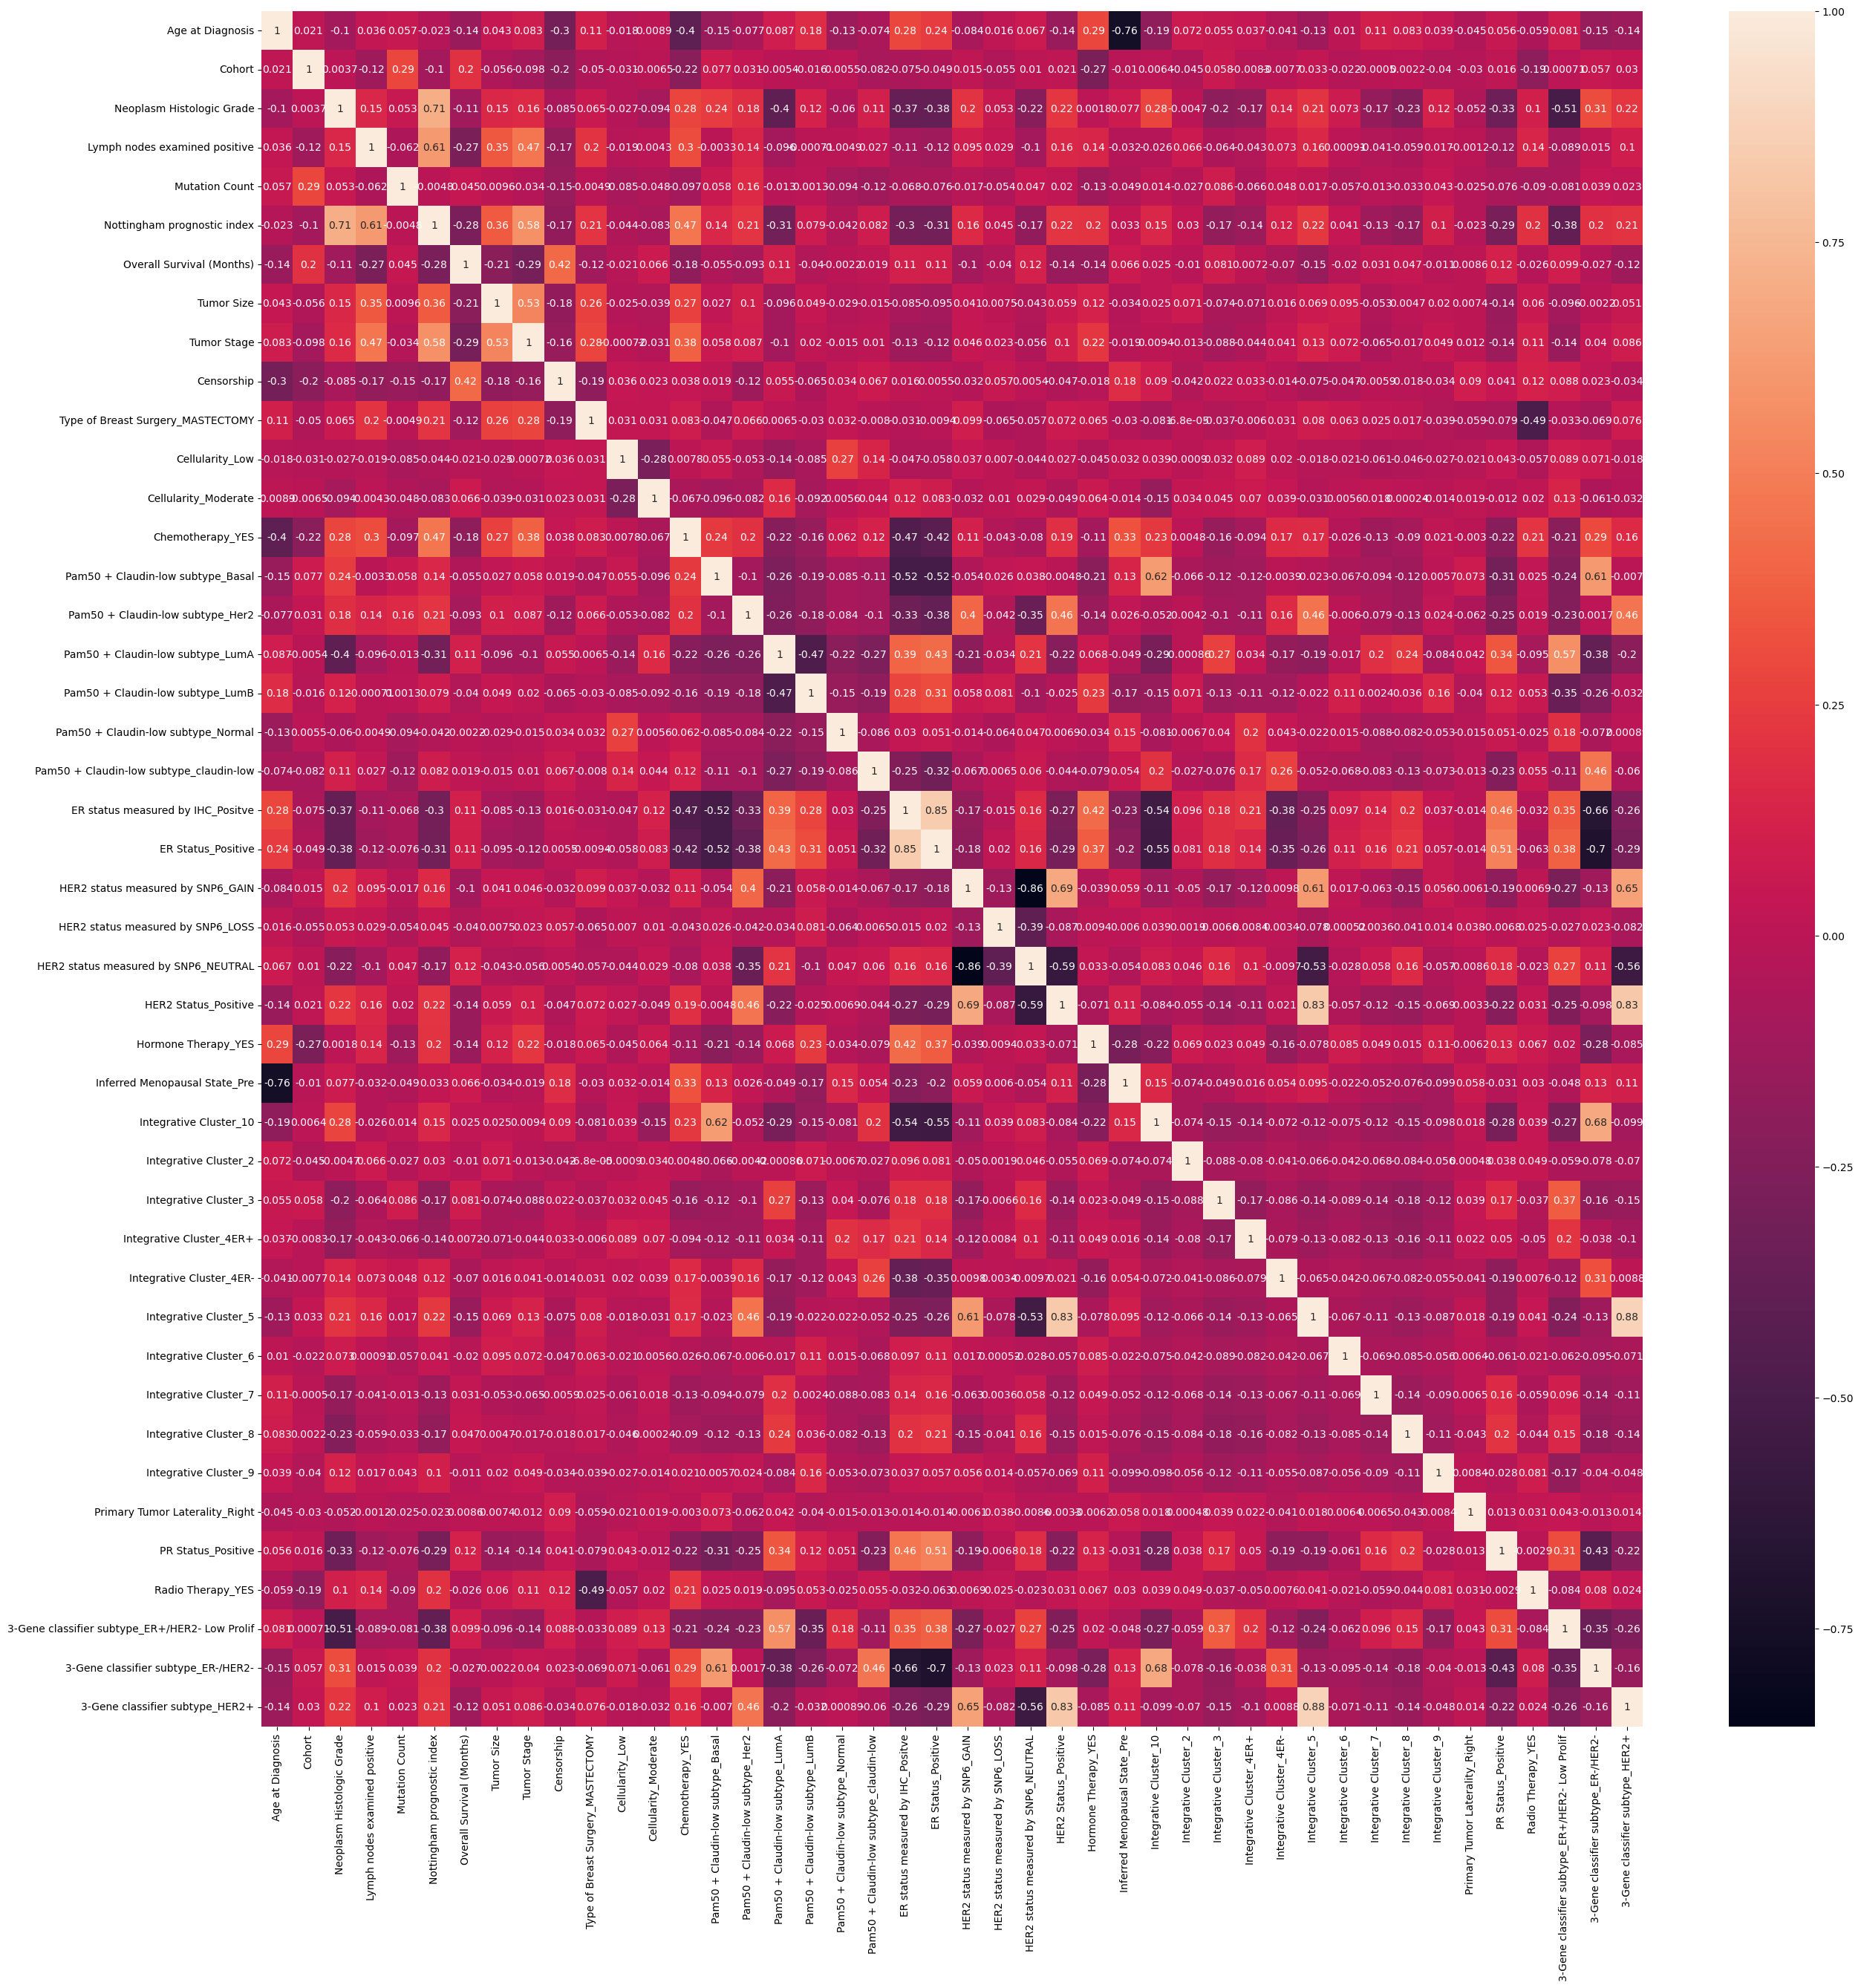

In [5]:
plt.figure(figsize=(30, 30))
sn.heatmap(df_train.corr(), annot=True)

In [6]:
X = df_train.drop([event_col, duration_col], axis = 1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                                           feature         VIF
0                                 Age at Diagnosis   60.376315
1                                           Cohort    8.441116
2                        Neoplasm Histologic Grade   63.907320
3                    Lymph nodes examined positive    2.874319
4                                   Mutation Count    3.578500
5                      Nottingham prognostic index  118.963150
6                                       Tumor Size    5.919310
7                                      Tumor Stage   21.126457
8                Type of Breast Surgery_MASTECTOMY    4.158067
9                                  Cellularity_Low    1.496737
10                            Cellularity_Moderate    1.950730
11                                Chemotherapy_YES    2.771251
12               Pam50 + Claudin-low subtype_Basal   36.200785
13                Pam50 + Claudin-low subtype_Her2   33.507820
14                Pam50 + Claudin-low subtype_LumA  145

In [7]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)
mean_concordance = 0.0
models = []
oof_preds = np.zeros((len(df_train), 1))
for i, (train_index, test_index) in enumerate(kf.split(df_train)):
    train = df_train.iloc[train_index]
    valid = df_train.iloc[test_index]

    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(train, duration_col = duration_col, event_col = event_col)
    concordance_index = cph.score(valid, scoring_method="concordance_index")

    print("Fold: ", i, "concordance index: ", concordance_index)
    
    mean_concordance += concordance_index

    oof_preds[test_index] = cph.predict_partial_hazard(valid).values.reshape(-1, 1)

    models.append(cph)
print("oof concordance index: ", lifelines.utils.concordance_index(df_train[duration_col].values, -oof_preds, df_train[event_col].values))


Fold:  0 concordance index:  0.7012882447665056
Fold:  1 concordance index:  0.76
Fold:  2 concordance index:  0.7826904985888994
Fold:  3 concordance index:  0.6474358974358975
Fold:  4 concordance index:  0.7104622871046229
Fold:  5 concordance index:  0.6791808873720137
Fold:  6 concordance index:  0.6988783433994823
Fold:  7 concordance index:  0.6915608663181478
Fold:  8 concordance index:  0.6869009584664537
Fold:  9 concordance index:  0.6972704714640199
oof concordance index:  0.7002116324892359


In [8]:
cph = CoxPHFitter(penalizer=0.01)
cph.fit(train, duration_col = duration_col, event_col = event_col)
concordance_index = cph.score(valid, scoring_method="concordance_index")

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 786 total observations, 444 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'Censorship'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 786
number of events observed = 342
   partial log-likelihood = -1706.36
         time fit was run = 2023-05-05 04:50:32 UTC

---
                                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                              
Age at Diagnosis                                -0.00       1.00       0.01            -0.02             0.01                 0.98                 1.01
Cohort                                          -0.55       0.58       0.09            -0.72            -0.38                 0.49                 0.68
Neoplasm Histologic Grade                        0.28       1.32       0.17            -0.06             0.62                 0.94                 1.85
Lymph nodes examined positive                    0.03       1.03       0.03            -0.03             0.08                 0.97                 1.09
Mutation Count                                  -0.06       0.94       0.02            -0.10            -0.02                 0.91                 0.98
Nottingham prognostic index                     -0.30       0.74       0.14            -0.59            -0.02                 0.56                 0.98
Tumor Size                                       0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
Tumor Stage                                      0.12       1.13       0.14            -0.16             0.40                 0.85                 1.50
Type of Breast Surgery_MASTECTOMY               -0.32       0.73       0.15            -0.61            -0.02                 0.54                 0.98
Cellularity_Low                                  0.10       1.11       0.19            -0.27             0.48                 0.76                 1.62
Cellularity_Moderate                            -0.07       0.93       0.13            -0.33             0.19                 0.72                 1.20
Chemotherapy_YES                                 0.53       1.70       0.20             0.13             0.93                 1.14                 2.54
Pam50 + Claudin-low subtype_Basal               -0.13       0.88       0.47            -1.05             0.80                 0.35                 2.22
Pam50 + Claudin-low subtype_Her2                -0.63       0.53       0.48            -1.57             0.31                 0.21                 1.37
Pam50 + Claudin-low subtype_LumA                -0.03       0.97       0.41            -0.84             0.77                 0.43                 2.16
Pam50 + Claudin-low subtype_LumB                 0.03       1.04       0.42            -0.79             0.86                 0.45                 2.36
Pam50 + Claudin-low subtype_Normal               0.33       1.39       0.45            -0.56             1.22                 0.57                 3.40
Pam50 + Claudin-low subtype_claudin-low         -0.03       0.97       0.45            -0.90             0.85                 0.41                 2.33
ER status measured by IHC_Positve               -0.18       0.84       0.31            -0.78             0.43                 0.46                 1.53
ER Status_Positive                              -0.50       0.60       0.32            -1.13             0.12                 0.32                 1.13
HER2 status measured by SNP6_GAIN                0.16       1.17       0.54            -0.90             1.21                 0.41                 3.35
HER2 status measured by SNP6_LOSS                0.40  

In [9]:
predictions = np.zeros(df_test.shape[0])
for model in models:
    predictions -= model.predict_partial_hazard(df_test)
predictions /= num_folds
lifelines.utils.concordance_index(df_test[duration_col], predictions, event_observed=df_test[event_col])

0.6505151768309663

In [10]:
from models import SurvModel, DeepHitModel
import torch
from pycox.models import DeepHitSingle
import warnings
import losses
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)


TIME_BINS = 20

oof_preds_surv = np.zeros((df_train.shape[0], 1))
oof_preds_hit = np.zeros((df_train.shape[0], TIME_BINS))

for i, (train_index, test_index) in enumerate(kf.split(df_train)):

    train = df_clear.iloc[train_index]
    valid = df_clear.iloc[test_index]

    model = SurvModel(df_train.copy(), events_col=event_col, time_col=duration_col, layers = [16,16,16,16], residual=True)
    
    history_surv = model.fit(epochs=300, lr=0.01, verbose=False, train_index=train_index, valid_index=test_index)
    oof_preds_surv[test_index] = model.predict(test_index)
    #utils.plot_history(history_surv, 'SurvModel')

    hit_model = DeepHitModel(df_train.copy(), events_col=event_col, time_col=duration_col, time_bins=TIME_BINS, interpolation_steps=10, layers = [32] * 7, dropout=0.4)
    history_hit = hit_model.fit(epochs=300, train_index=train_index, valid_index=test_index, lr=0.01, verbose=False)



    oof_preds_hit[test_index] = hit_model.predict(test_index)
    #utils.plot_history(history_hit, 'DeepHit')

    num_durations = 10
    labtrans = DeepHitSingle.label_transform(num_durations)

    x = train.drop([event_col, duration_col], axis=1).values.astype('float32')
    y = labtrans.fit_transform(train[duration_col].values, train[event_col].values)
    
    val_x = valid.drop([event_col, duration_col], axis=1).values.astype('float32')
    val_y = labtrans.fit_transform(valid[duration_col].values, valid[event_col].values)


    in_features = x.shape[1]
    num_nodes = [64, 32, 16]
    out_features = num_durations
    batch_norm = True
    dropout = 0.1
    output_bias = False
    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout, output_bias = output_bias).float()

    m = DeepHitSingle(net, tt.optim.Adam)
    m.optimizer.set_lr(0.01)
    log = m.fit(x, y, batch_size=256, epochs=50, verbose=False)

    surv = m.predict_surv_df(val_x)
    ev = EvalSurv(surv, val_y[0], val_y[1], censor_surv='km')

    print(f'Fold {i}')
    #print(f'loss {losses.negative_likelihood_loss(valid_preds, torch.tensor(valid[duration_col].values, dtype=torch.float))}') 
    print(f'package concordance {ev.concordance_td("antolini")}, surv concordance {np.max(history_surv["val_c_index"])}, hit concordance {np.max(history_hit["val_c_index"])}')
hit_oof = hit_model.concordance_index(torch.tensor(oof_preds_hit), (torch.tensor(hit_model.x), torch.tensor(hit_model.events), torch.tensor(hit_model.time), torch.tensor(hit_model.continous_time), torch.tensor(hit_model.mask )))
surv_oof = model.concordance_index(torch.tensor(oof_preds_surv), (torch.tensor(model.x), torch.tensor(model.events), torch.tensor(model.time)))
print(f'oof concordance, hit {hit_oof}, surv {surv_oof} ')


Fold 0
package concordance 0.7772065124250214, surv concordance 0.727810650887574, hit concordance 0.6706924315619968
Fold 1
package concordance 0.7527372262773723, surv concordance 0.7506613756613757, hit concordance 0.6851063829787234
Fold 2
package concordance 0.7536687631027253, surv concordance 0.776541095890411, hit concordance 0.6415804327375353
Fold 3
package concordance 0.7012320328542094, surv concordance 0.7743664717348928, hit concordance 0.6720085470085471
Fold 4
package concordance 0.7006472491909385, surv concordance 0.7463002114164905, hit concordance 0.6512570965125709
Fold 5
package concordance 0.6658354114713217, surv concordance 0.760485651214128, hit concordance 0.6689419795221843
Fold 6
package concordance 0.7753201396973225, surv concordance 0.8091106290672451, hit concordance 0.6876617773943055
Fold 7
package concordance 0.7182080924855492, surv concordance 0.7924693520140105, hit concordance 0.6624346527259148
Fold 8
package concordance 0.7475961538461539, surv

C:\Users\User\AppData\Local\Temp\ipykernel_27772\2155485396.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hit_oof = hit_model.concordance_index(torch.tensor(oof_preds_hit), (torch.tensor(hit_model.x), torch.tensor(hit_model.events), torch.tensor(hit_model.time), torch.tensor(hit_model.continous_time), torch.tensor(hit_model.mask )))


oof concordance, hit 0.509847802995289, surv 0.7327835753727894 


In [11]:
from models import SurvModel, DeepHitModel
import torch
from pycox.models import DeepHitSingle
import warnings
import losses
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

def train_hit(config):

    TIME_BINS = config["time_bins"]
    oof_preds_hit = np.zeros((df_train.shape[0], TIME_BINS))

    for i, (train_index, test_index) in enumerate(kf.split(df_train)):

        train = df_clear.iloc[train_index]
        valid = df_clear.iloc[test_index]
        

        hit_model = DeepHitModel(df_train.copy(), events_col=event_col, time_col=duration_col, time_bins=TIME_BINS, interpolation_steps=config["interpolation_steps"]
                                 , layers = [config["layer_size"]] * config["num_layers"], dropout=config["dropout"], residual=config["residual"], batch_size=config["batch_size"])
        hit_model.fit(epochs=300, train_index=train_index, valid_index=test_index, lr=config["lr"], verbose=False, weight_decay=config["weight_decay"])
        oof_preds_hit[test_index] = hit_model.predict(test_index)
        

    hit_oof = hit_model.concordance_index(torch.tensor(oof_preds_hit), (torch.tensor(hit_model.x), torch.tensor(hit_model.events), torch.tensor(hit_model.time), torch.tensor(hit_model.continous_time), torch.tensor(hit_model.mask)))
    hit_oof_loss = losses.deep_hit_loss(torch.tensor(oof_preds_hit), hit_model.mask).detach().numpy()
    tune.report(loss = hit_oof_loss, c_index=hit_oof)

def train_surv(config):
        oof_preds_surv = np.zeros((df_train.shape[0], 1))
    
        for i, (train_index, test_index) in enumerate(kf.split(df_train)):
    
            train = df_clear.iloc[train_index]
            valid = df_clear.iloc[test_index]
    
            model = SurvModel(df_train.copy(), events_col=event_col, time_col=duration_col, layers = [config["layer_size"]] * config["num_layers"], dropout=config["dropout"],
                              residual=config["residual"], batch_size=config["batch_size"])
            model.fit(epochs=300, train_index=train_index, valid_index=test_index, lr=config["lr"], verbose=False, weight_decay=config["weight_decay"])
            
            oof_preds_surv[test_index] = model.predict(test_index)
    
        surv_oof = model.concordance_index(torch.tensor(oof_preds_surv), (torch.tensor(model.x), torch.tensor(model.events), torch.tensor(model.time)))
        surv_oof_loss = losses.negative_likelihood_loss(torch.tensor(oof_preds_surv), torch.tensor(model.events, dtype=torch.float)).detach().numpy()
        tune.report(loss = surv_oof_loss, c_index=surv_oof)

hit_config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "dropout": tune.uniform(0.1, 0.5),
    "layer_size": tune.choice([16, 32, 64]),
    "num_layers": tune.choice([3, 4, 5, 6, 7]),
    "weight_decay": tune.loguniform(1e-4, 1e-1),
    "time_bins": tune.choice([10, 20, 30, 40, 50]),
    "interpolation_steps": tune.choice([5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
    "residual" : tune.choice([True, False]),
    "batch_size": tune.choice([32, 64, 128, 256])
}

surv_config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "dropout": tune.uniform(0.1, 0.5),
    "layer_size": tune.choice([16, 32, 64]),
    "num_layers": tune.choice([3, 4, 5, 6, 7]),
    "weight_decay": tune.loguniform(1e-4, 1e-1),
    "residual" : tune.choice([True, False]),
    "batch_size": tune.choice([32, 64, 128, 256, 512, 1024, 2048])
}



In [12]:
analysis_hit = tune.run(
    train_hit,
    config=hit_config,
    num_samples=100,
    resources_per_trial={"cpu": 1, "gpu": 0},
    metric="c_index",
    mode="max",
    name="hit",
    local_dir="~/ray_results"
)
print(f'best score{analysis_hit.get_best_trial(metric="c_index", mode="max").last_result["c_index"]}, best config {analysis_hit.get_best_trial(metric="c_index", mode="max").config}')

2023-05-04 16:53:02,805	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


2023-05-04 16:54:14,358	WARNING worker.py:1866 -- Traceback (most recent call last):
  File "python\ray\_raylet.pyx", line 850, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 902, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 857, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 861, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 803, in ray._raylet.execute_task.function_executor
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "d:\Users\User\anaconda3\envs\SurvAnalysis\lib\site-packages\ray\_private\function_manager.py", line 586, in temporary_actor_method
    raise RuntimeError(
RuntimeError: The actor with name ImplicitFunc failed to import on the worker. This may be because needed library dependencies are not installed in the worker environment:

Traceback (most rece

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_36728\700902672.py", line 11, in <module>
    print(f'best score{analysis_hit.get_best_trial(metric="c_index", mode="max").last_result["c_index"]}, best config {analysis_hit.get_best_trial(metric="c_index", mode="max").config}')
AttributeError: 'NoneType' object has no attribute 'last_result'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\IPython\core\ultratb.py", line 1118, in structured_traceback
    return FormattedT

In [ ]:
analysis_surv = tune.run(
    train_surv,
    config=surv_config,
    num_samples=100,
    resources_per_trial={"cpu": 1, "gpu": 0},
    metric="c_index",
    mode="max",
    name="surv",
    local_dir="~/ray_results"
)
print(f'best score{analysis_surv.get_best_trial(metric="c_index", mode="max").last_result["c_index"]}, best config {analysis_surv.get_best_trial(metric="c_index", mode="max").config}')

Trial name,c_index,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_surv_9e8c9_00006,0.546013,2023-04-28_17-32-28,False,,687b997caa9d402b82440c9fd04b11cc,DESKTOP-670FM4Q,1,5.37188,127.0.0.1,5316,68.2442,68.2442,68.2442,1682695948,0,,1,9e8c9_00006,0.00600171
train_surv_9e8c9_00010,0.46503,2023-04-28_17-32-33,True,,57c8aff8ffc14a13a2abc935f3612039,DESKTOP-670FM4Q,1,5.3911,127.0.0.1,26440,44.0657,44.0657,44.0657,1682695953,0,,1,9e8c9_00010,0.00600195


2023-04-28 17:36:09,312	WARNING tensorboardx.py:224 -- You are trying to log an invalid value (ray/tune/loss=nan) via TBXLoggerCallback!
2023-04-28 17:36:09,312	WARNING tensorboardx.py:224 -- You are trying to log an invalid value (ray/tune/loss=nan) via TBXLoggerCallback!
2023-04-28 17:43:30,039	INFO tune.py:798 -- Total run time: 775.14 seconds (775.08 seconds for the tuning loop).


best score0.7471175831481992, best config {'lr': 0.020727716954668914, 'dropout': 0.21115496839813033, 'layer_size': 64, 'num_layers': 6, 'weight_decay': 0.000254866287166362, 'residual': True}
